In [35]:
import glob
import pandas as pd
import seaborn as sns

In [ ]:
path = "Datos"
 
Archivos = glob.glob(path + "/*.xlsx")
 
ListaExcel = []
 
for Archivo in Archivos:
    ListaExcel.append(pd.read_excel(Archivo))
 

sismos = pd.DataFrame()
 
for excel in ListaExcel:

    sismos = sismos.append(
      excel, ignore_index=True)

In [21]:
sismos.head()

,FECHA,HORA_UTC,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,MAGNITUD Mw,DEPARTAMENTO,MUNICIPIO,# FASES,RMS (Seg),GAP (grados),ERROR LATITUD (Km),ERROR LONGITUD (Km),ERROR PROFUNDIDAD (Km),ESTADO,FechaCompleta
0,1993-06-01,01:32:55,6.795,-73.052,150.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,8.7,10.0,8.6,Revisado,1993-06-01 01:32:55
1,1993-06-01,03:08:28,6.790,-73.053,152.5,3.0,NaN,SANTANDER,LOS_SANTOS,4,0.3,320.0,10.3,9.8,8.9,Revisado,1993-06-01 03:08:28
2,1993-06-01,10:13:18,6.839,-73.105,152.1,2.9,NaN,SANTANDER,LOS_SANTOS,4,0.5,321.0,13.2,12.3,11.2,Revisado,1993-06-01 10:13:18
3,1993-06-01,10:34:45,6.894,-73.171,150.0,2.9,NaN,SANTANDER,BETULIA,4,0.3,308.0,8.6,9.5,8.4,Revisado,1993-06-01 10:34:45
4,1993-06-01,15:31:24,6.754,-73.058,150.0,4.4,NaN,SANTANDER,JORDAN,9,0.5,308.0,8.9,8.1,7.6,Revisado,1993-06-01 15:31:24


In [22]:
sismos.columns

Index(['FECHA', 'HORA_UTC', 'LATITUD (grados)', 'LONGITUD (grados)',
       'PROFUNDIDAD (Km)', 'MAGNITUD Ml', 'MAGNITUD Mw', 'DEPARTAMENTO',
       'MUNICIPIO', '# FASES', 'RMS (Seg)', 'GAP (grados)',
       'ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)',
       'ESTADO', 'FechaCompleta'],
      dtype='object')

In [23]:
sismos.dtypes

FECHA                             object
HORA_UTC                          object
LATITUD (grados)                 float64
LONGITUD (grados)                float64
PROFUNDIDAD (Km)                 float64
MAGNITUD Ml                      float64
MAGNITUD Mw                      float64
DEPARTAMENTO                      object
MUNICIPIO                         object
# FASES                            int64
RMS (Seg)                        float64
GAP (grados)                     float64
ERROR LATITUD (Km)               float64
ERROR LONGITUD (Km)              float64
ERROR PROFUNDIDAD (Km)           float64
ESTADO                            object
FechaCompleta             datetime64[ns]
dtype: object

In [ ]:
sismos["FechaCompleta"] = pd.to_datetime(sismos.FECHA+" "+ sismos.HORA_UTC)

In [26]:
sismos = sismos.drop(columns=['FECHA','HORA_UTC','MAGNITUD Mw','RMS (Seg)', 'GAP (grados)',
       'ERROR LATITUD (Km)', 'ERROR LONGITUD (Km)', 'ERROR PROFUNDIDAD (Km)',
       'ESTADO'])

In [27]:
sismos

,LATITUD (grados),LONGITUD (grados),PROFUNDIDAD (Km),MAGNITUD Ml,DEPARTAMENTO,MUNICIPIO,# FASES,FechaCompleta
0,6.795,-73.052,150.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 01:32:55
1,6.790,-73.053,152.5,3.0,SANTANDER,LOS_SANTOS,4,1993-06-01 03:08:28
2,6.839,-73.105,152.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 10:13:18
3,6.894,-73.171,150.0,2.9,SANTANDER,BETULIA,4,1993-06-01 10:34:45
4,6.754,-73.058,150.0,4.4,SANTANDER,JORDAN,9,1993-06-01 15:31:24
...,...,...,...,...,...,...,...,...
176374,4.099,-74.079,1.7,1.9,CUNDINAMARCA,GUTIERREZ,14,2018-02-27 15:01:57
176375,6.799,-73.154,141.9,1.8,SANTANDER,LOS_SANTOS,8,2018-02-27 22:58:56
176376,9.701,-72.835,2.1,1.9,CESAR,BECERRIL,14,2018-02-27 23:26:43
176377,5.402,-76.840,0.0,1.8,CHOCO,RIO_QUITO,6,2018-02-28 15:17:34


In [30]:
columns_dict = {"LATITUD (grados)":"Latitud",
                "LONGITUD (grados)":"Longitud",
                "PROFUNDIDAD (Km)":"Produndidad",
                "MAGNITUD Ml":"Magnitud_ML",
                "DEPARTAMENTO":"Departamento",
                "MUNICIPIO":"Municipio",
                "# FASES":"Fases"
               }
sismos = sismos.rename(columns=columns_dict)

In [31]:
sismos.head()

,Latitud,Longitud,Produndidad,Magnitud_ML,Departamento,Municipio,Fases,FechaCompleta
0,6.795,-73.052,150.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 01:32:55
1,6.790,-73.053,152.5,3.0,SANTANDER,LOS_SANTOS,4,1993-06-01 03:08:28
2,6.839,-73.105,152.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 10:13:18
3,6.894,-73.171,150.0,2.9,SANTANDER,BETULIA,4,1993-06-01 10:34:45
4,6.754,-73.058,150.0,4.4,SANTANDER,JORDAN,9,1993-06-01 15:31:24


In [32]:
sismos["Año"] = sismos.FechaCompleta.dt.year
sismos["Mes"] = sismos.FechaCompleta.dt.month
sismos["Dia"] = sismos.FechaCompleta.dt.weekday

In [33]:
sismos.head()

,Latitud,Longitud,Produndidad,Magnitud_ML,Departamento,Municipio,Fases,FechaCompleta,Año,Mes,Dia
0,6.795,-73.052,150.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 01:32:55,1993,6,1
1,6.790,-73.053,152.5,3.0,SANTANDER,LOS_SANTOS,4,1993-06-01 03:08:28,1993,6,1
2,6.839,-73.105,152.1,2.9,SANTANDER,LOS_SANTOS,4,1993-06-01 10:13:18,1993,6,1
3,6.894,-73.171,150.0,2.9,SANTANDER,BETULIA,4,1993-06-01 10:34:45,1993,6,1
4,6.754,-73.058,150.0,4.4,SANTANDER,JORDAN,9,1993-06-01 15:31:24,1993,6,1


In [55]:
sismos = sismos[(sismos.Año >=1994) &(sismos.Año <=2017)]

<AxesSubplot: title={'center': 'Accidenst By Month'}>

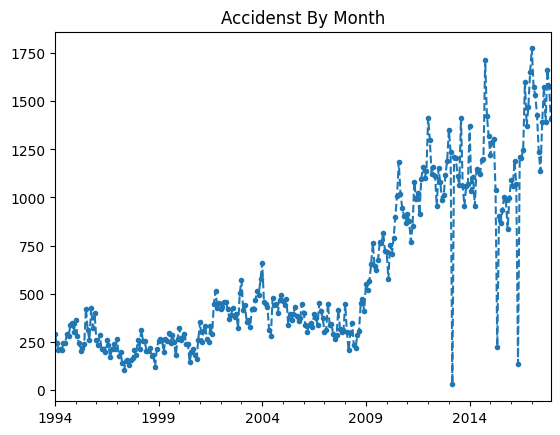

In [59]:
month = pd.to_datetime(sismos.FechaCompleta).dt.to_period(freq = 'M')
monthly_accidents = month.value_counts().sort_index()

monthly_accidents.plot(marker='.', ls = '--', title = 'Accidenst By Month')

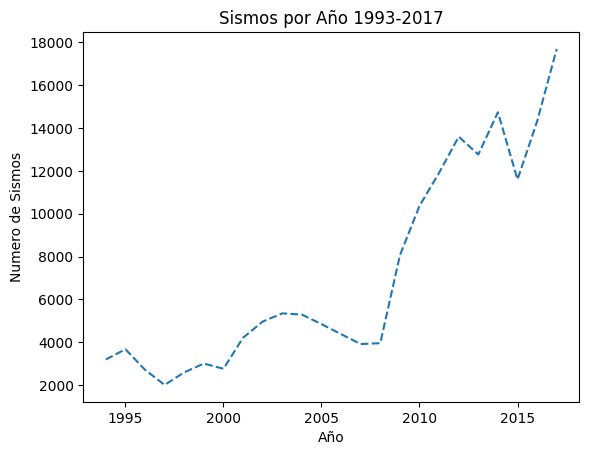

In [56]:
sismosaño = sismos.Año.value_counts().sort_index()
gpsa = sns.lineplot(sismosaño)
gpsa.set(xlabel='Año', ylabel="Numero de Sismos", title='Sismos por Año 1993-2017')
gpsa.lines[0].set_linestyle("--")

<AxesSubplot: title={'center': 'Accidenst By Month'}>

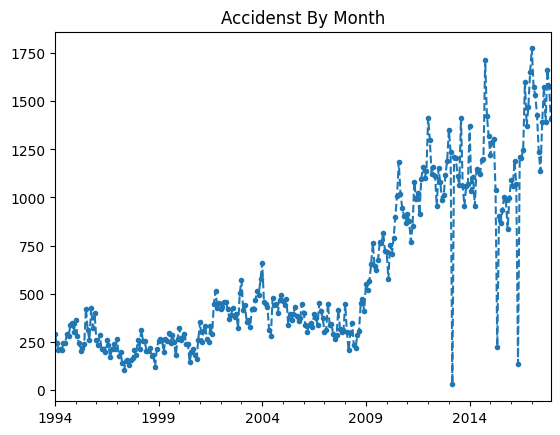

In [67]:
month = sismos.FechaCompleta.dt.to_period(freq = 'M')
monthly_accidents = month.value_counts().sort_index()
monthly_accidents.plot(marker='.', ls = '--', title = 'Accidenst By Month')


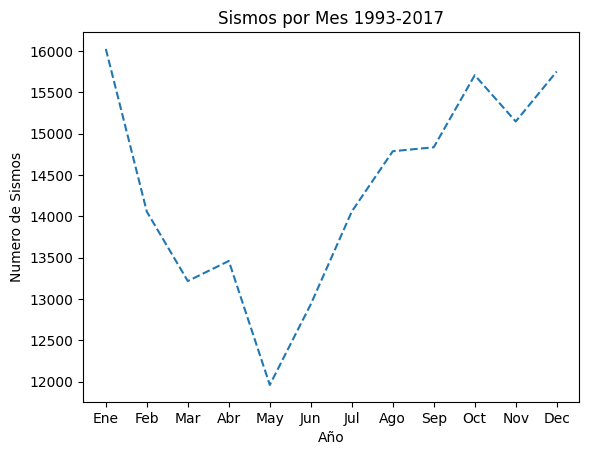

In [57]:
sismosmes = sismos.Mes.value_counts().sort_index()
sismosmes.index = ['Ene','Feb','Mar','Abr','May','Jun', 'Jul','Ago','Sep','Oct','Nov','Dec']
gpsa = sns.lineplot(sismosmes)
gpsa.set(xlabel='Año', ylabel="Numero de Sismos", title='Sismos por Mes 1993-2017')
gpsa.lines[0].set_linestyle("--")

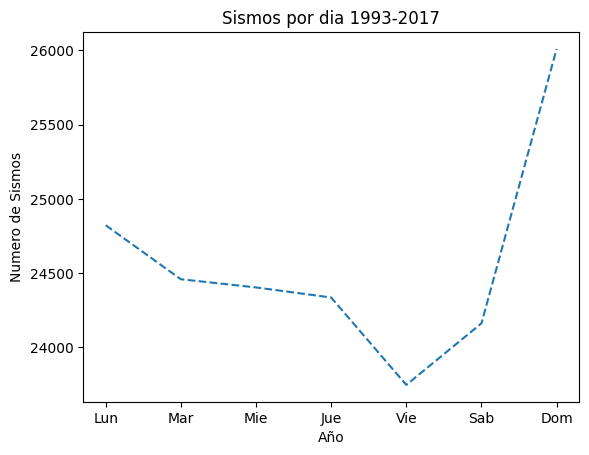

In [58]:
sismosdia = sismos.Dia.value_counts().sort_index()
sismosdia.index = ['Lun','Mar','Mie','Jue','Vie','Sab','Dom']
gpsa = sns.lineplot(sismosdia)
gpsa.set(xlabel='Año', ylabel="Numero de Sismos", title='Sismos por dia 1993-2017')
gpsa.lines[0].set_linestyle("--")